In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from src import loader, rdit

MAGDIR = '/scratch/fl1092/MAG/2021-12-06/'
PROJDIR = '/scratch/fl1092/COIpaper/'
COLABDIR = '/scratch/fl1092/followup-editors/collab/'

In [2]:
from datetime import datetime, timedelta

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Load data

In [3]:
papEditor = loader.loadPaperEditor()
assert(papEditor.shape[0] == papEditor[['PaperId','EditorId']].drop_duplicates().shape[0])
assert(papEditor.shape[0] == papEditor.PaperId.nunique())

info = loader.loadPaperInfo()

recvDate, acptDate = loader.loadPaperRecvAcptTime()

In [4]:
paperDate = pd.read_csv(MAGDIR+'derived/PaperDate.csv',sep='\t',parse_dates=['Date'])

In [5]:
%%time
papAu = pd.read_csv(COLABDIR + 'PaperAuthorSubset.csv', sep='\t')

colabYear = (
    pd.read_csv(PROJDIR + 'EditorColabYear.csv')
    # all papers and authors that the editor has written; and year of publication of those papers
    
    .merge(paperDate.rename(columns={'Date':'ColabDate'}), on='PaperId')
)

CPU times: user 2min 18s, sys: 30.9 s, total: 2min 49s
Wall time: 3min 38s


# Compute longitudinal percentage of papers with recent editor-author collaborations

In [6]:
def getPaperByPub(publisher, info=info, recvDate=recvDate):
    
    # filter all the paper for a specific publisher and get the date when those papers are received
    return (
        info.query(f'Publisher == "{publisher}"')
        .merge(recvDate.drop('Year',axis=1), on='PaperId')
    )

In [7]:
%%time
paperEditorRecentColabHandle = (
    # these are the authors that editor both collaborated recently and handle their papers
    papEditor
    .merge(recvDate, on='PaperId')
    .merge(papAu, on='PaperId')
    
    .merge(
        colabYear.rename(columns={'Year':'ColabYear','PaperId':'OtherPaper'}),
        on=['EditorId','AuthorId']
    )
    
    .assign(MonthGap=lambda df: df.apply(lambda row: diff_month(row.RecvDate, row.ColabDate), axis=1))
    .assign(Later=lambda df: df.RecvDate >= df.ColabDate)
    .query('Later == True')
)

CPU times: user 35.9 s, sys: 5.92 s, total: 41.8 s
Wall time: 1min 23s


In [8]:
mostRecent = (
    paperEditorRecentColabHandle
    .groupby(['PaperId','EditorId']).MonthGap.min().reset_index()
)

timesCollaborated = (
    paperEditorRecentColabHandle
    .query('MonthGap <= 48')
    .groupby('PaperId').OtherPaper.nunique().reset_index()
    .rename(columns={'ColabPaperId':'NoPastCollab'})
)

In [9]:
%%time
pnasPapers = getPaperByPub('pnas')
plosPapers = getPaperByPub('plos')

COIoverTime = (
    pnasPapers
    .merge(papEditor.rename(columns={'publisher':'Publisher'}), on=['PaperId', 'Publisher'])
    .drop('EditorId', axis=1)
    
    ### time of most recent prior collaboration ###
    .merge(
        mostRecent.drop('EditorId', axis=1)
        
        .assign(Less24=lambda df: df.MonthGap.apply(lambda x: x <= 24))
        .assign(Less48More24=lambda df: df.MonthGap.apply(lambda x: x > 24 and x <= 48)),
        
        on=['PaperId'], how='left'
    )
    .fillna({'Less48More24': False, 'Less24': False})
    
    .assign(RecvMonth=lambda df: df.RecvDate.apply(rdit.converMonth))
)

COIoverTimePLOS = (
    plosPapers
    .merge(papEditor.rename(columns={'publisher':'Publisher'}), on=['PaperId', 'Publisher'])
    .drop('EditorId', axis=1)
    
    ### time of most recent prior collaboration ###
    .merge(
        mostRecent
        
        .assign(Less60=lambda df: df.MonthGap.apply(lambda x: x <= 60))
        .assign(More60=lambda df: df.MonthGap.apply(lambda x: x >= 60)),
        
        on=['PaperId'], how='left'
    )
    .fillna({'Less60': False, 'More60': False})
    .assign(RecvMonth=lambda df: df.RecvDate.apply(rdit.converMonth))
)

COIoverTime[['Less24','Less48More24','RecvMonth']].to_csv('./data/PNAS_RDiT.csv',index=False)
COIoverTimePLOS[['Journal','Less60','More60','RecvMonth']].to_csv('./data/PLOS_RDiT.csv',index=False)

CPU times: user 1.35 s, sys: 136 ms, total: 1.49 s
Wall time: 3 s


# RDiT

-1.83\% -0.16\% 0.26\%
(0.029) (0.783) (0.233)
-0.10\% -0.02\% -0.01\%
(0.000) (0.373) (0.158)
120.0 120.0 120.0


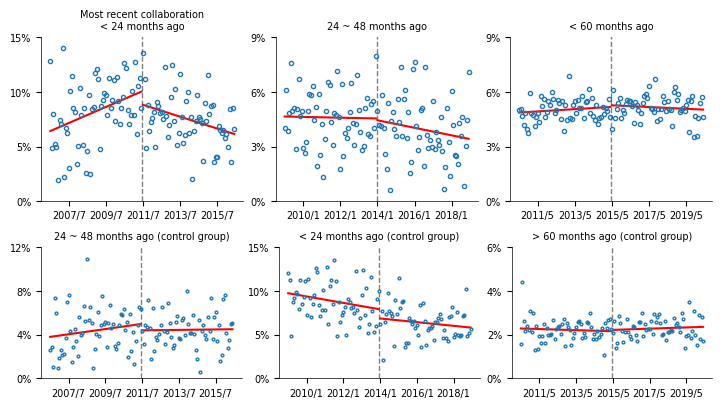

In [10]:
rdit.plotRDiT(60, COIoverTime, COIoverTimePLOS)
plt.savefig('./figures/RDiT.pdf', bbox_inches = 'tight', pad_inches = 0)

-1.84\% -0.16\% 0.27\%
(0.036) (0.798) (0.248)
-0.10\% -0.03\% -0.00\%
(0.001) (0.107) (0.751)
108.0 108.0 108.0


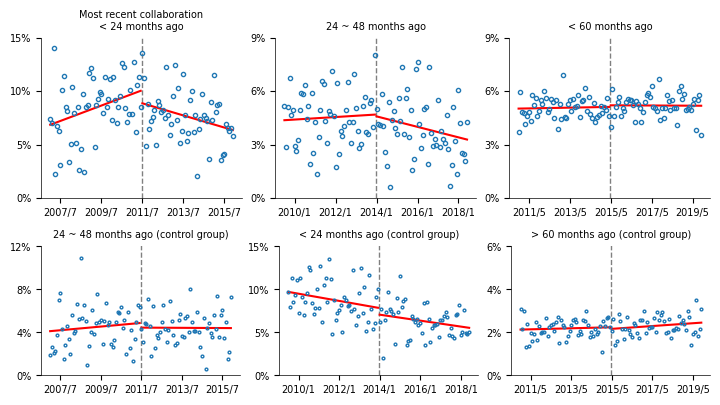

In [11]:
rdit.plotRDiT(54, COIoverTime, COIoverTimePLOS)

-2.15\% -0.24\% 0.29\%
(0.024) (0.709) (0.182)
-0.10\% -0.04\% 0.01\%
(0.010) (0.066) (0.299)
96.0 96.0 96.0


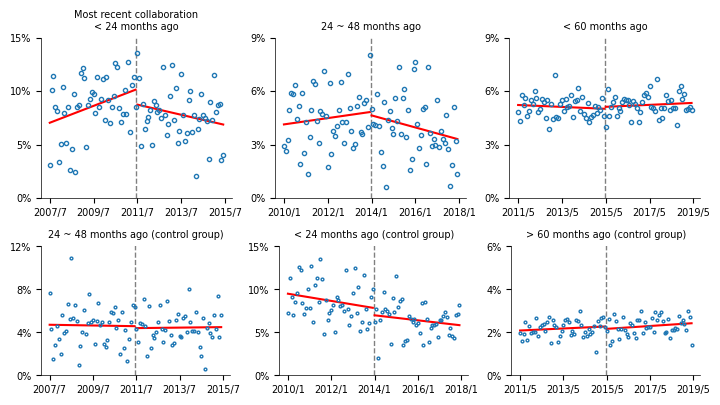

In [12]:
rdit.plotRDiT(48, COIoverTime, COIoverTimePLOS)

-2.27\% -0.55\% 0.33\%
(0.023) (0.412) (0.169)
-0.11\% -0.02\% 0.01\%
(0.011) (0.451) (0.189)
84.0 84.0 84.0


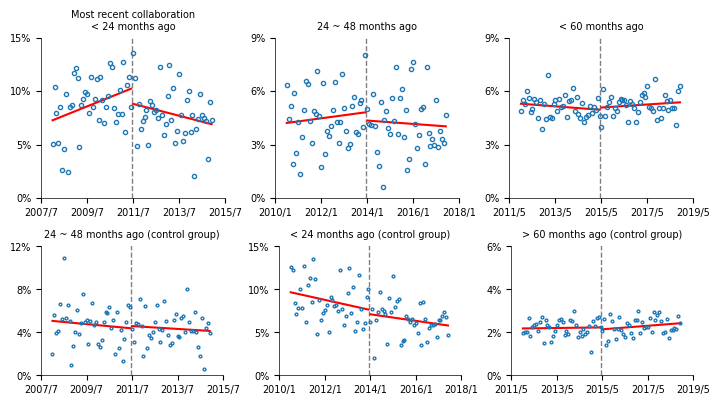

In [13]:
rdit.plotRDiT(42, COIoverTime, COIoverTimePLOS)

-2.10\% -0.74\% 0.34\%
(0.065) (0.314) (0.191)
-0.09\% -0.02\% 0.01\%
(0.157) (0.601) (0.412)
72.0 72.0 72.0


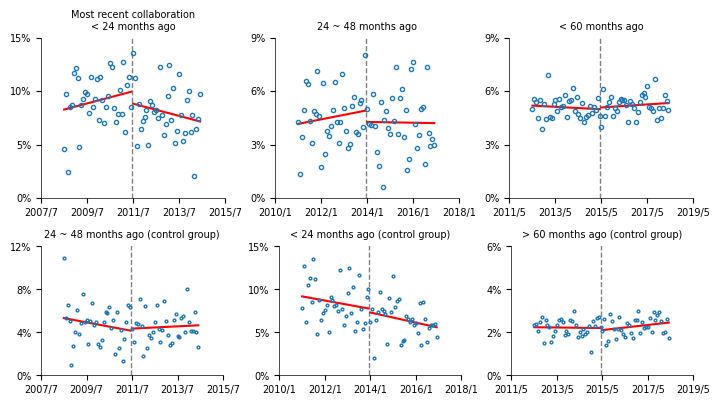

In [14]:
rdit.plotRDiT(36, COIoverTime, COIoverTimePLOS)